# Do vanilla analysis and compute metrics

# Plan
## (TO DO) Vanilla analysis
 * QC cells and features
 * Normalization
 * Feature selection
 * Dimensionality reduction
 * Clustering
 * DE test
## Separability of the latent space
 * Proportion of neighbors metric (in R)
 * (TO DO) Make figures (improve the graphics)
## DE ground truth
 * (TO DO) based on the largest dataset with true labels (entire Memory B vs entire Naive B)
 * (TO DO) based on true labels for each Frankenstein dataset
## Precision and Recall of DE
 * (TO DO) Compute
 * (TO DO) Make figure

In [1]:
# external dependencies
import os
import sys
notebook_path = os.path.abspath('.')
sources_path = os.path.abspath(os.path.join(notebook_path, '..'))
sys.path.insert(0, sources_path)
# import custom modules
import utils
import models
import dataloaders

# basic imports
import json
import pprint
import pickle
import logging
from tqdm.auto import tqdm, trange

# scientific python
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import scipy as sp
import pandas as pd

# Scanpy modules
import scanpy as sc
import anndata

logger = logging.getLogger()
utils.matplotlib_settings()
utils.print_module_versions([sc, anndata])

scanpy    : 1.6.0
anndata   : 0.7.4


# Vanilla analysis in scanpy

## Load the preprocessed data

In [2]:
# save np.load
np_load_old = np.load
# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [6]:
# puck data prefix
PREFIX = 'citeseq_rna'#'sn'
PUCK_SUBNUMBER = 'naiveB_1900'#'mli2_30'
PUCK_NUMBER = f'{PUCK_SUBNUMBER}_memoryB_100' #f'{PUCK_SUBNUMBER}genes_0.05_perturbed'

dirname = f'latent_space_structure/data/{PREFIX}_{PUCK_NUMBER}'

np_data = np.load(os.path.join(dirname, 'preprocessed_data.npz'))
print(list(np_data.keys()))
adata = sc.read(os.path.join(dirname, 'adata.h5ad'))

batch = pd.read_csv(f'latent_space_structure/data/{PUCK_NUMBER}/batch.csv')['x'].values
perturbed = pd.read_csv(f'latent_space_structure/data/{PUCK_NUMBER}/celltype.csv')['x'].values

negative_batch_mask = batch == 0
positive_batch_mask = batch == 1
negative_perturbed_mask = perturbed == "Naive B"
positive_perturbed_mask = perturbed == "Memory B"

adata.obs['batch'] = batch
adata.obs['perturbed'] = perturbed
log_normalized_expression_ng = adata.X

['puck_number', 'n_filtered_genes', 'bead_efficiency_hvgs_n', 'bead_efficiency_n', 'filtered_expression_gn', 'mean_umi_hvgs', 'filtered_gene_names', 'bead_barcodes_n']


In [7]:
adata

AnnData object with n_obs × n_vars = 2000 × 17009
    obs: 'barcodes', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'batch', 'perturbed'
    var: 'gene_ids', 'mean', 'std'
    uns: 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
#adata.obs['batch'] = batch.astype('str')
#sc.tl.rank_genes_groups(adata, 'batch', groups=['1'], reference='0', method='wilcoxon')
#sc.pl.rank_genes_groups(adata, groups=['1'], n_genes=20)

## DE ground truth
 * based all Memory B vs all Naive B cells in the dataset

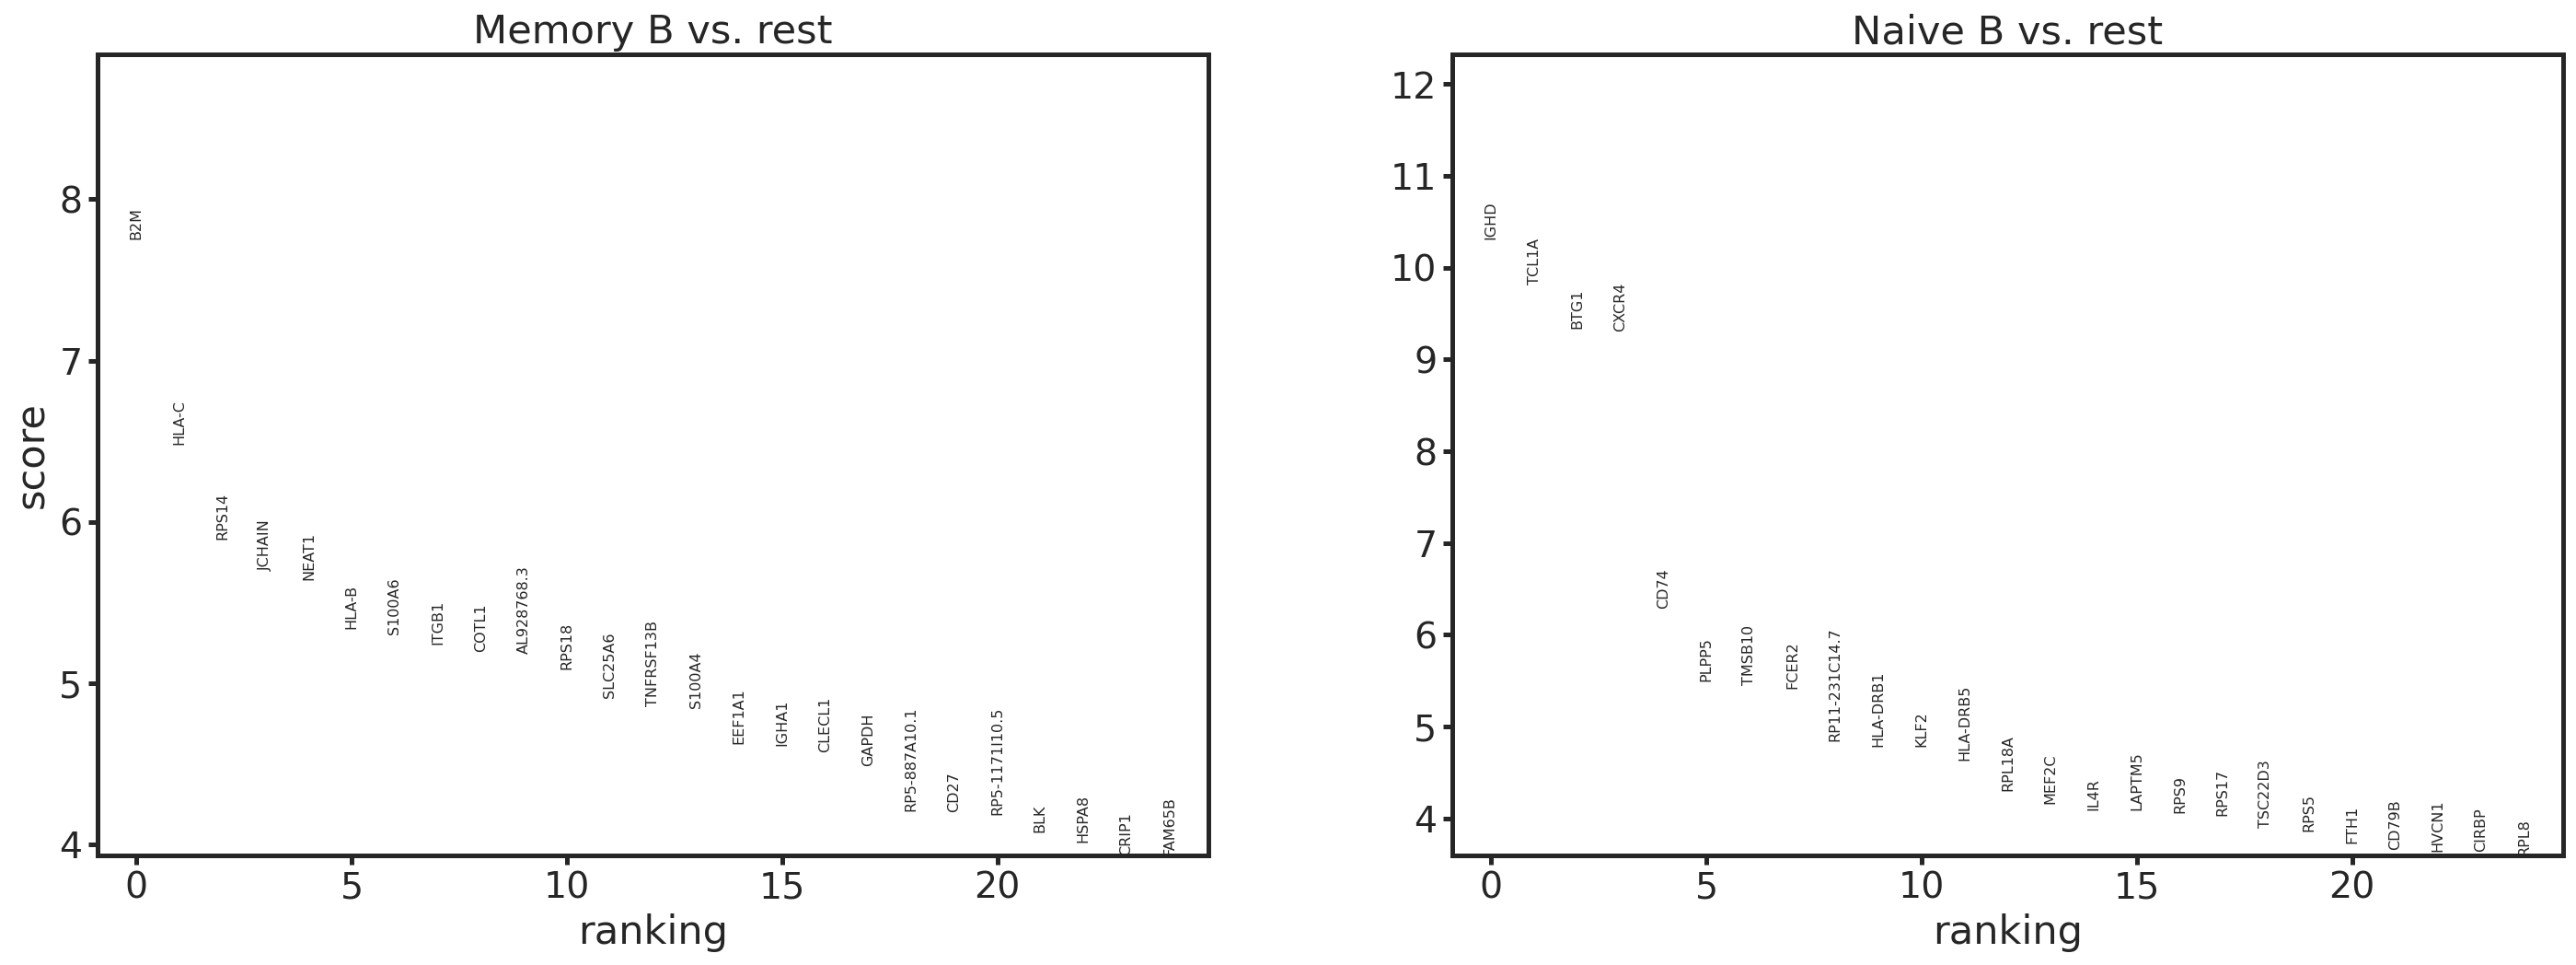

In [10]:
# classic uni-variate approach, with true labels
sc.tl.rank_genes_groups(adata, 'perturbed', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [13]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
result_df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})
result_memory_df = result_df[['Memory B_n', 'Memory B_p', 'Memory B_l']]
result_naive_df = result_df[['Naive B_n', 'Naive B_p', 'Naive B_l']]
naive_DEs = result_naive_df.loc[result_naive_df['Naive B_p']<0.01].loc[result_naive_df['Naive B_l']>0.25]['Naive B_n'].values
memory_DEs = result_memory_df.loc[result_memory_df['Memory B_p']<0.01].loc[result_memory_df['Memory B_l']>0.25]['Memory B_n'].values
print(naive_DEs.shape, memory_DEs.shape, result_df.shape)

(12,) (16,) (17009, 6)


In [23]:
#sc.pl.violin(adata, naive_DEs, groupby='perturbed')

In [20]:
#np.max(result_memory_df['Memory B_l'])

/opt/conda/envs/vizi/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


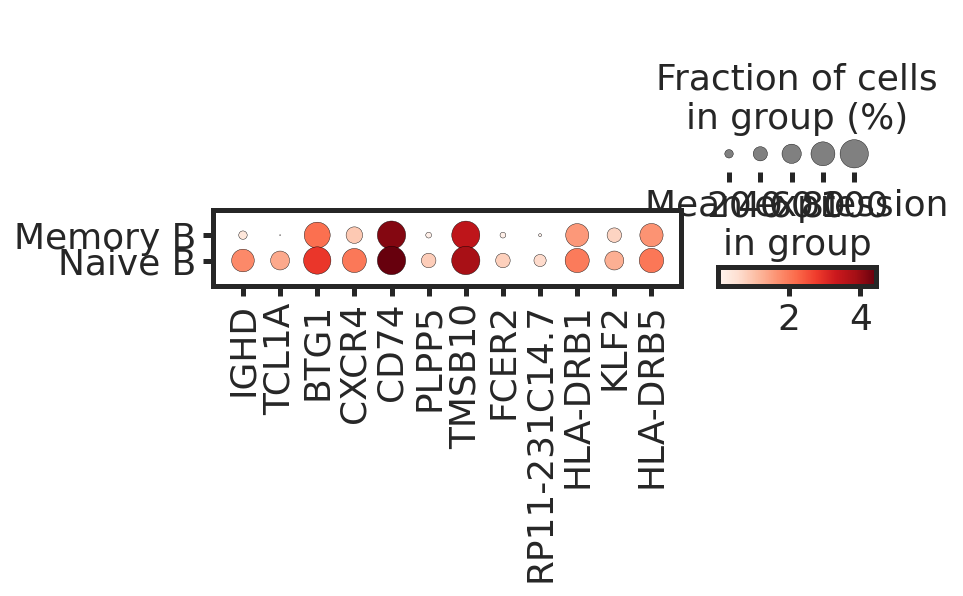

In [25]:
sc.pl.dotplot(adata, naive_DEs, groupby='perturbed')

/opt/conda/envs/vizi/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


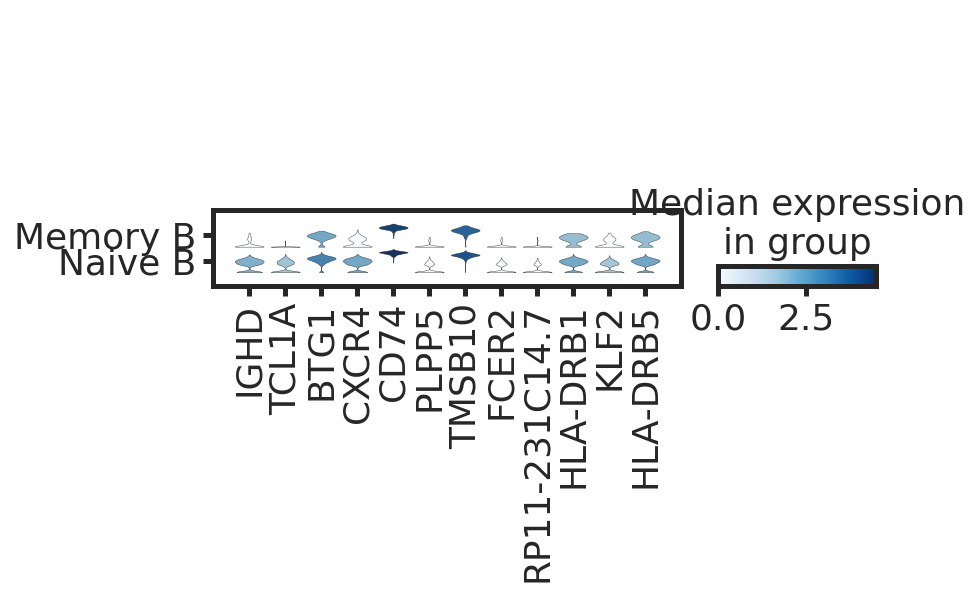

In [22]:
sc.pl.stacked_violin(adata, naive_DEs, groupby='perturbed')

/opt/conda/envs/vizi/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


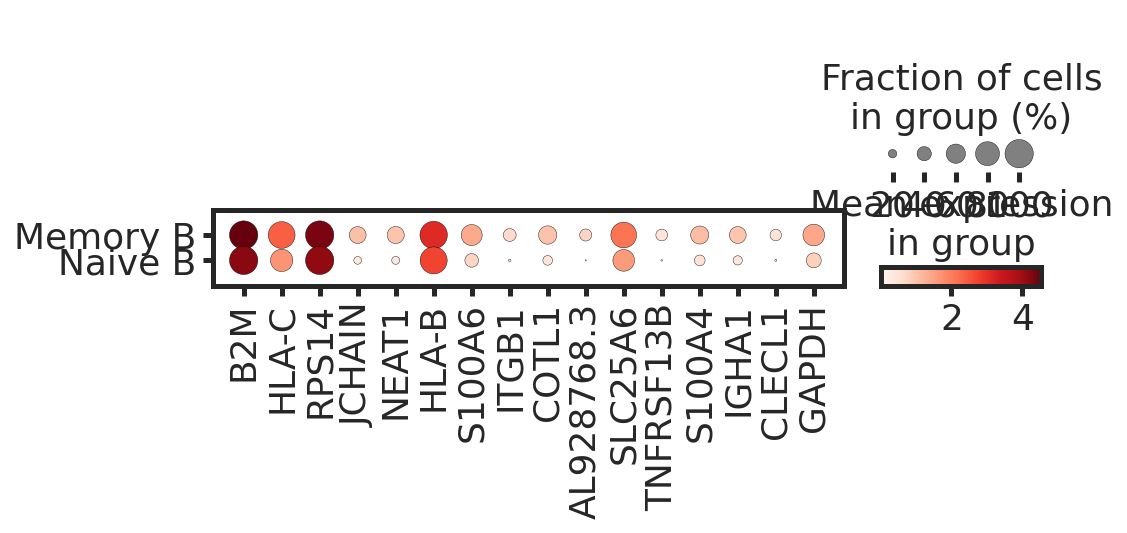

In [26]:
sc.pl.dotplot(adata, memory_DEs, groupby='perturbed')

/opt/conda/envs/vizi/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


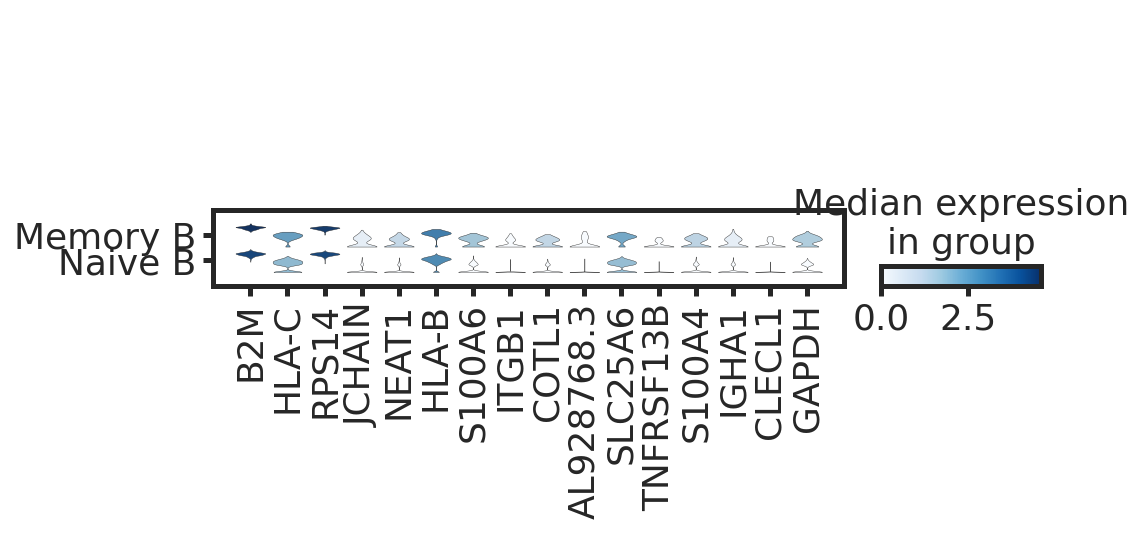

In [31]:
sc.pl.stacked_violin(adata, memory_DEs, groupby='perturbed')

### Check if there are any DE genes between Naive B cells between the two batches

In [40]:
adata_naiveB = adata[adata.obs['perturbed'].isin(['Naive B'])]

/opt/conda/envs/vizi/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


/opt/conda/envs/vizi/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
Trying to set attribute `.uns` of view, copying.


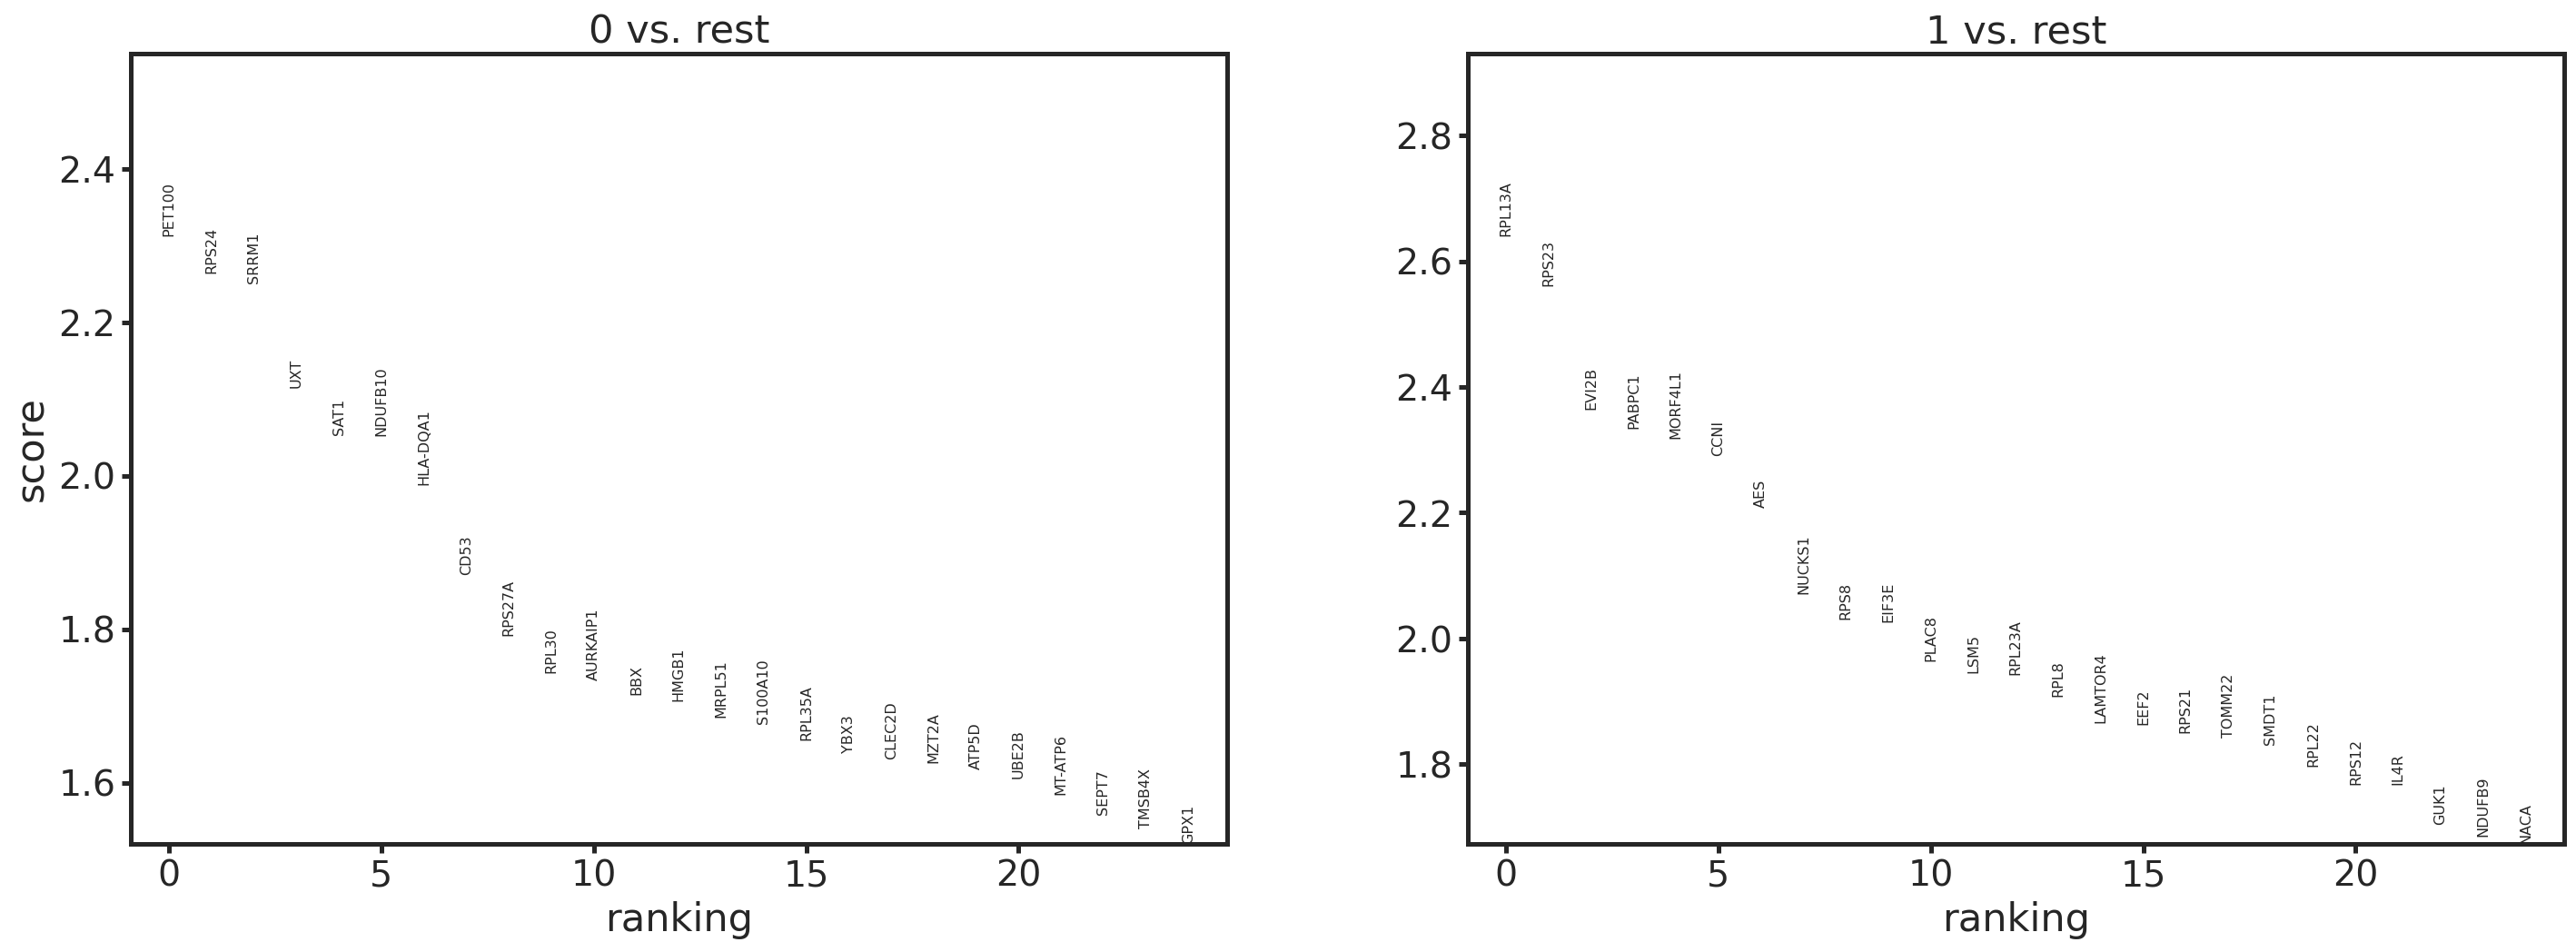

In [42]:
# classic uni-variate approach, with true labels
sc.tl.rank_genes_groups(adata_naiveB, 'batch', method='wilcoxon')
sc.pl.rank_genes_groups(adata_naiveB, n_genes=25, sharey=False)

In [43]:
result_naiveB = adata_naiveB.uns['rank_genes_groups']
groups = result_naiveB['names'].dtype.names


In [46]:
result_naiveB_df = pd.DataFrame(
    {group + '_' + key[:1]: result_naiveB[key][group]
    for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})

In [50]:
result_naive_0_df = result_naiveB_df[['0_n', '0_p', '0_l']]
result_naive_1_df = result_naiveB_df[['1_n', '1_p', '1_l']]

In [52]:
naiveB_0_DEs = result_naive_0_df.loc[result_naive_0_df['0_p']<0.01].loc[result_naive_0_df['0_l']>0.25]['0_n'].values
naiveB_1_DEs = result_naive_1_df.loc[result_naive_1_df['1_p']<0.01].loc[result_naive_1_df['1_l']>0.25]['1_n'].values
print(naiveB_0_DEs.shape, naiveB_1_DEs.shape, result_naiveB_df.shape)

(0,) (0,) (17009, 6)


In [ ]:
sklearn.metrics.precision_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')[source]

In [8]:
adata.obs['batch'] = batch.astype('str')

/opt/conda/envs/vizi/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'batch' as categorical
... storing 'perturbed' as categorical


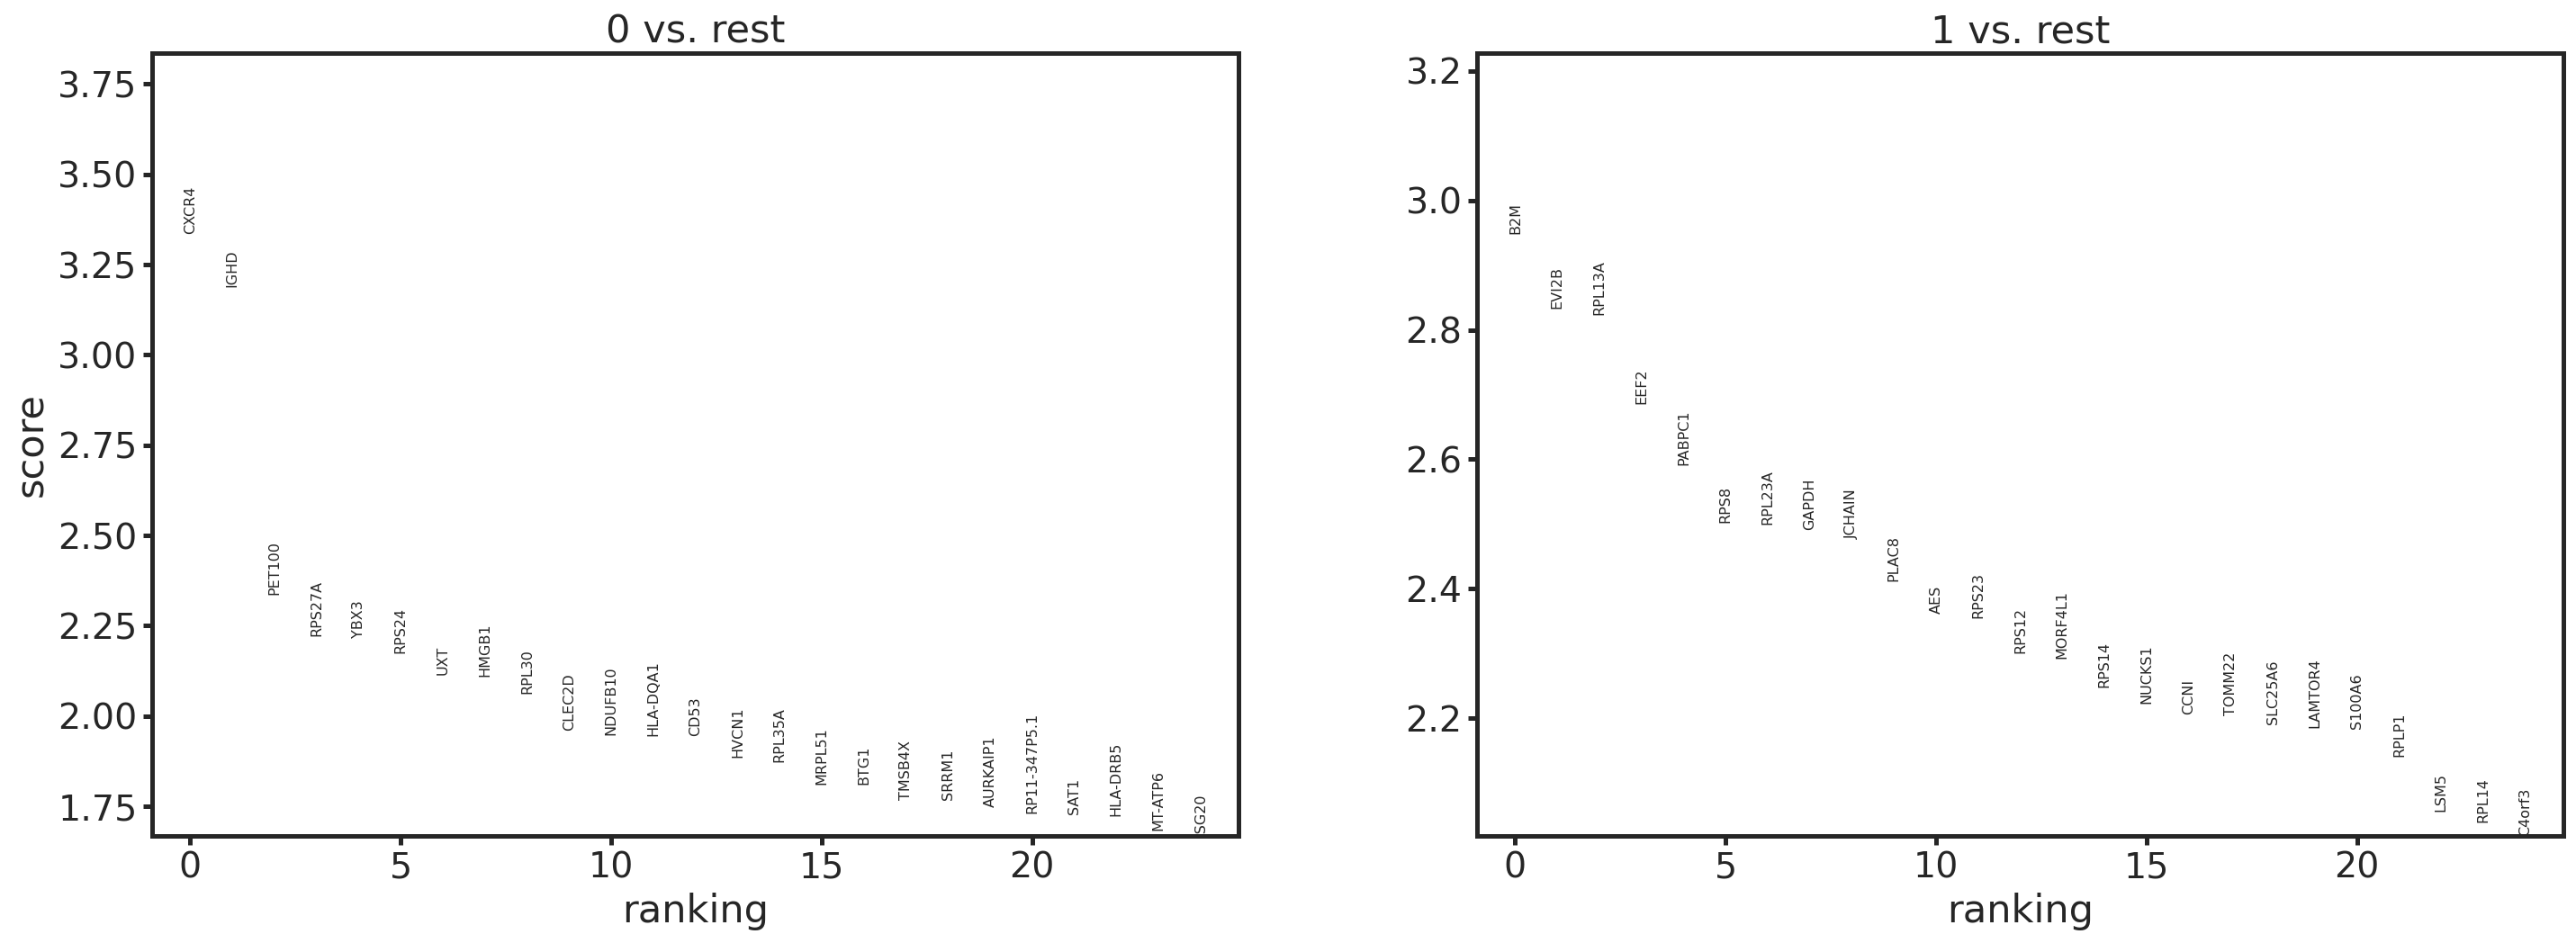

In [9]:
# classic uni-variate approach, global labels
sc.tl.rank_genes_groups(adata, 'batch', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
# multi-variate alternative DE test with logistic regression
#sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
#sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

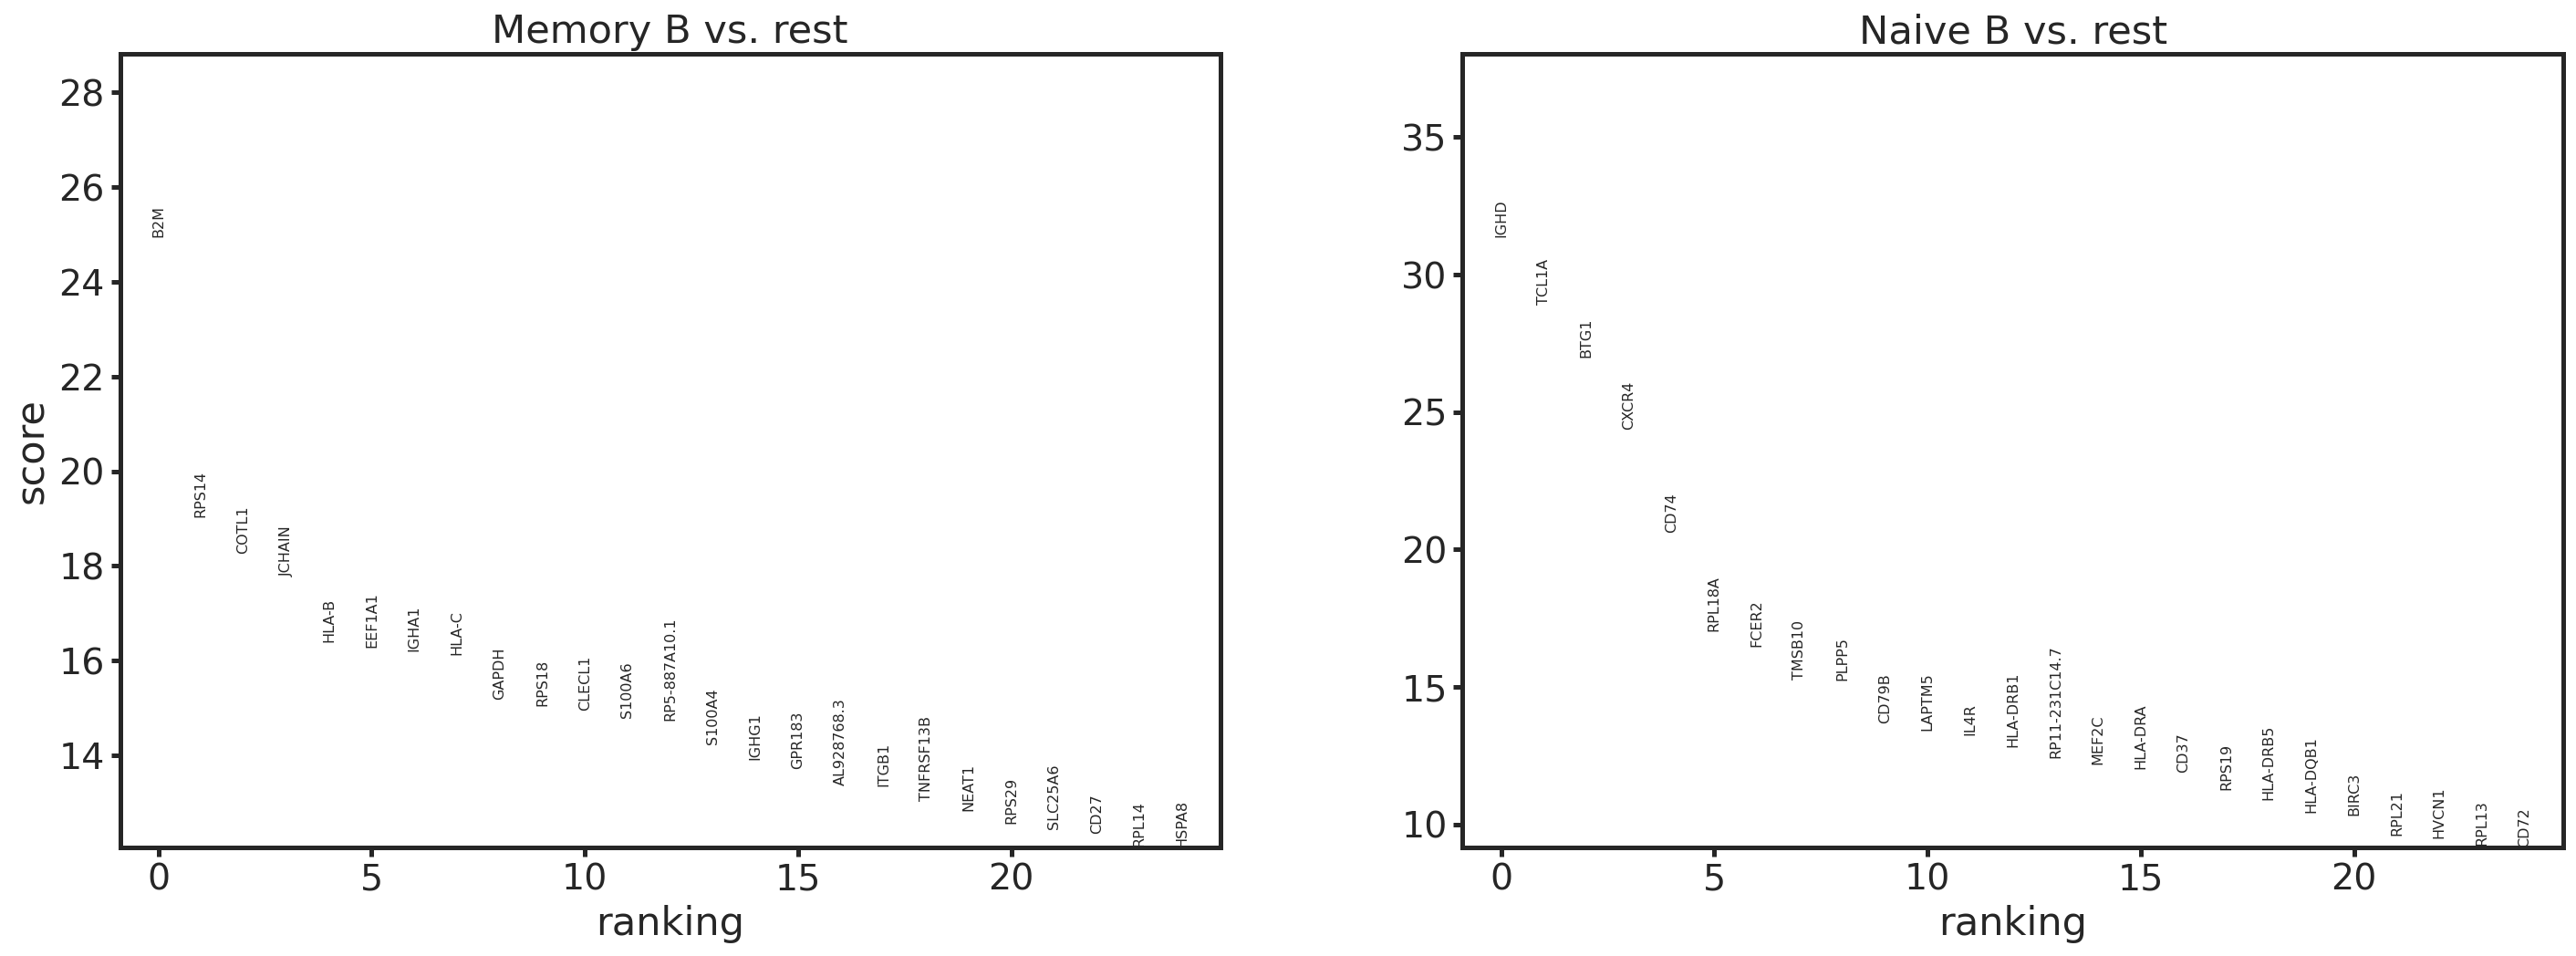

In [34]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,Memory B,Naive B
0,B2M,IGHD
1,RPS14,TCL1A
2,COTL1,BTG1
3,JCHAIN,CXCR4
4,HLA-B,CD74


(68,) (238,) (17009, 6)


24.752739

In [23]:
sc.pl.rank_genes_groups_violin(adata, groups='Memory B', n_genes=8)

Exception: Data must be 1-dimensional

## Scale Data for PCA

In [164]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_log_normalized_expression_ng = scaler.fit_transform(log_normalized_expression_ng)

## Utility functions

In [165]:
from sklearn.linear_model import LogisticRegression
import scipy as sp
from scipy.stats import describe as describe_stats


def standalone_logistic(X, y):
    clf = LogisticRegression(random_state=RAND_SEED, penalty='none').fit(X, y)
    predicted_label = clf.predict(X)
    predicted_prob = clf.predict_proba(X)
    return predicted_prob[:,1]

## PCA (already storred in the adata)

In [166]:
adata.obsm['X_pca']

array([[-1.1143863e+00,  6.7914510e+00, -2.6475270e+00, ...,
         2.2634945e+00,  2.4945824e+00,  1.9797338e+00],
       [-7.2413783e+00,  1.0897363e+00,  1.3623663e+00, ...,
        -1.8596071e+00,  1.4892654e+00, -1.3838010e+00],
       [-1.0377420e+01,  7.2668964e-01,  6.5199003e+00, ...,
         1.4654067e+00,  3.9927526e+00,  1.1923137e+00],
       ...,
       [ 5.2058764e+00, -1.2121801e+00, -1.0142019e+00, ...,
         9.2349648e-01, -3.4892926e-01,  1.7043571e+00],
       [ 8.6246281e+00, -5.3848257e+00, -8.9992929e-01, ...,
        -4.2900562e+00, -1.9321675e+00,  4.3137956e+00],
       [ 6.6212234e+00, -3.1082470e+00, -3.2598598e+00, ...,
        -3.0667429e+00, -3.6924416e-03,  2.4787366e+00]], dtype=float32)

## UMAP of PCA

/opt/conda/envs/vizi/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'perturbed' as categorical


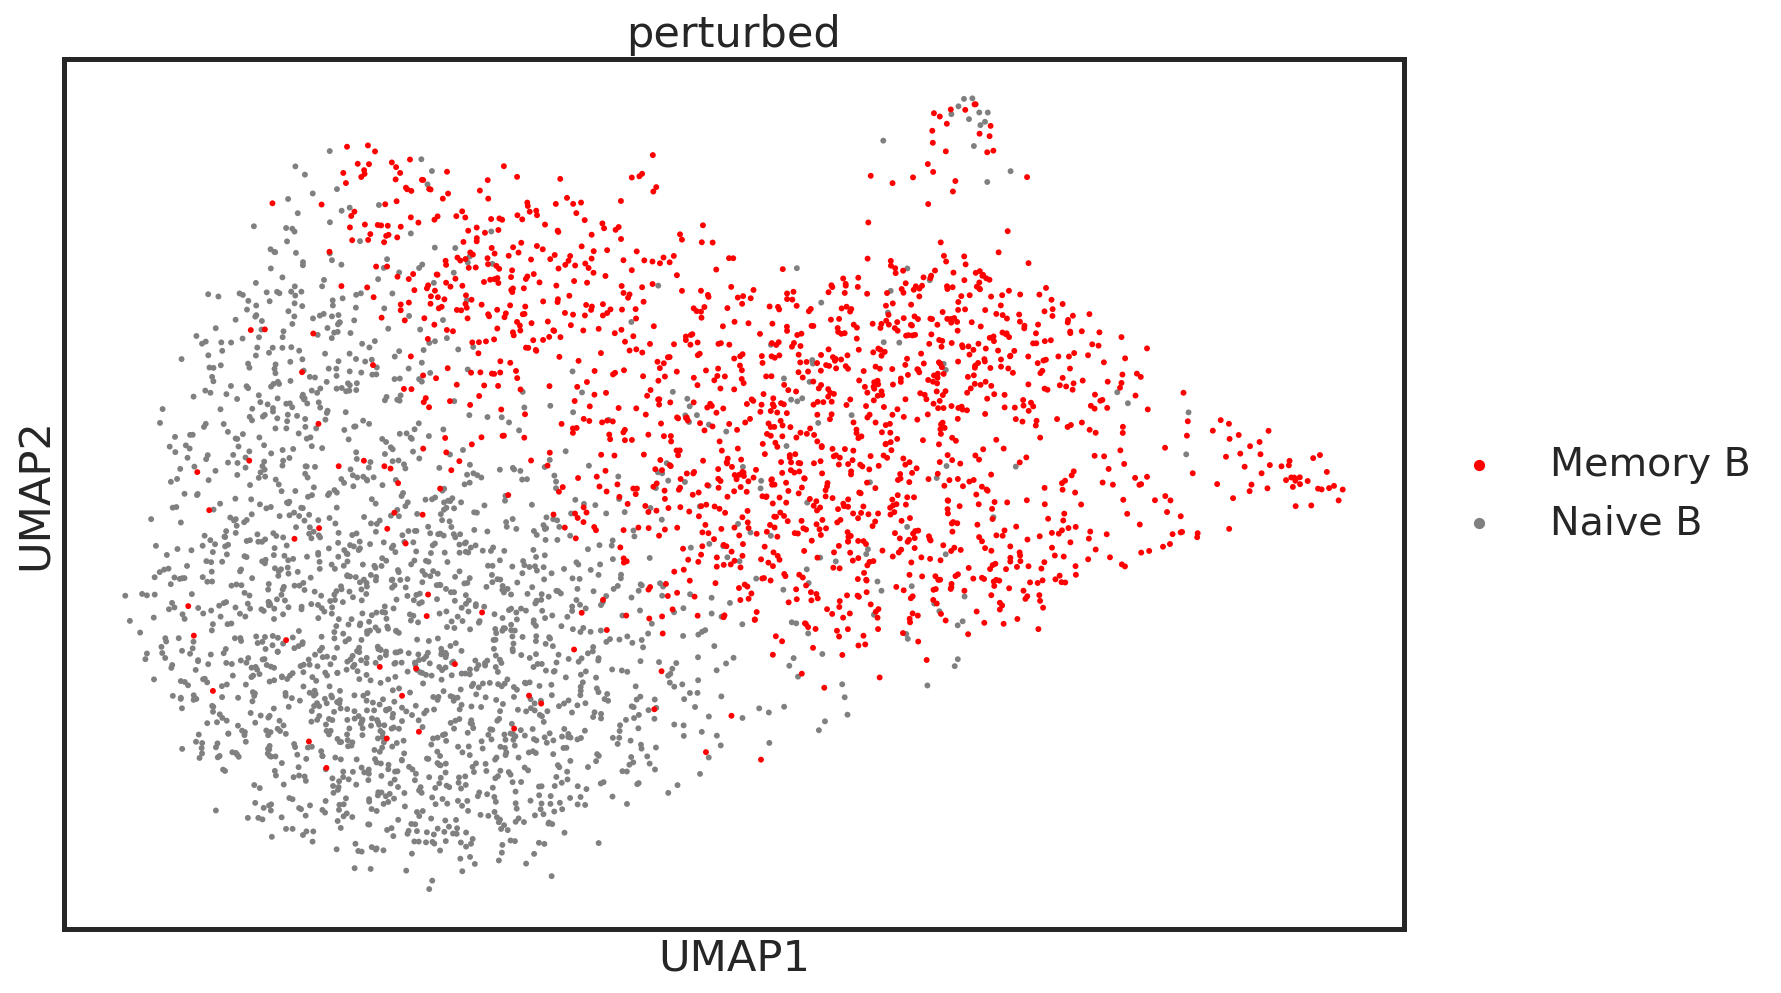

In [167]:
sc.pl.umap(adata, color='perturbed', palette=['red', 'gray'])

In [168]:
adata.obs['batch'] = batch
adata.obs['batch'] = adata.obs['batch'].astype('str')

... storing 'batch' as categorical


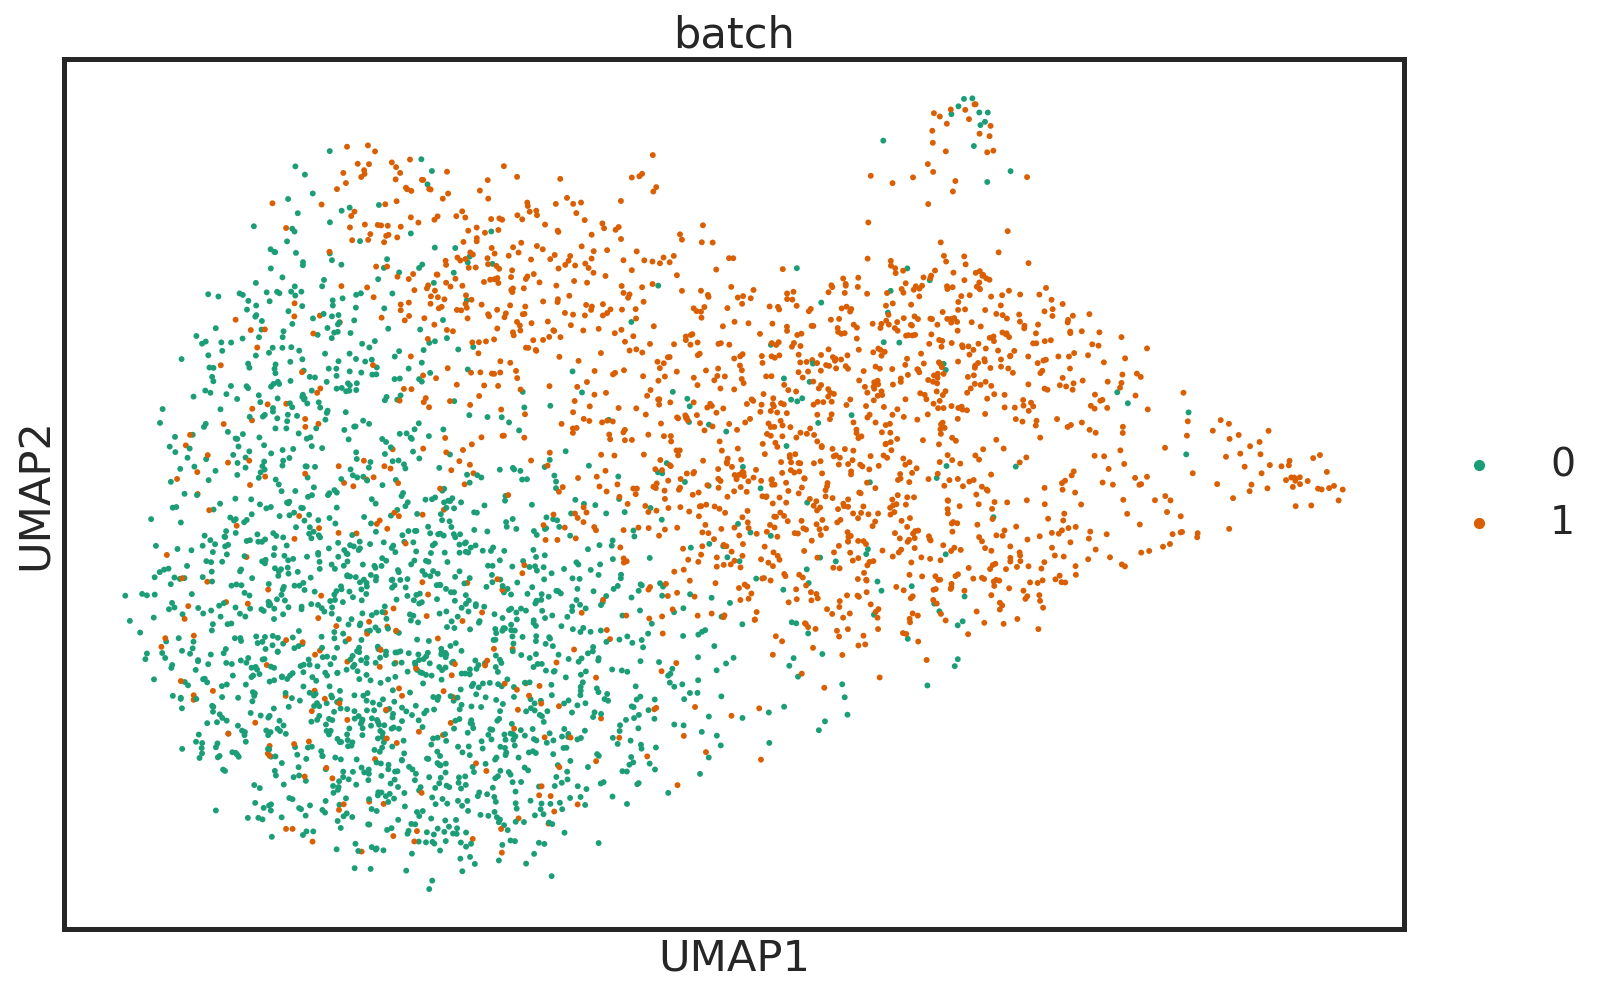

In [169]:
sc.pl.umap(adata, color='batch', palette=["#1B9E77", "#D95F02"])

In [170]:
#scaled_log_normalized_expression_ng

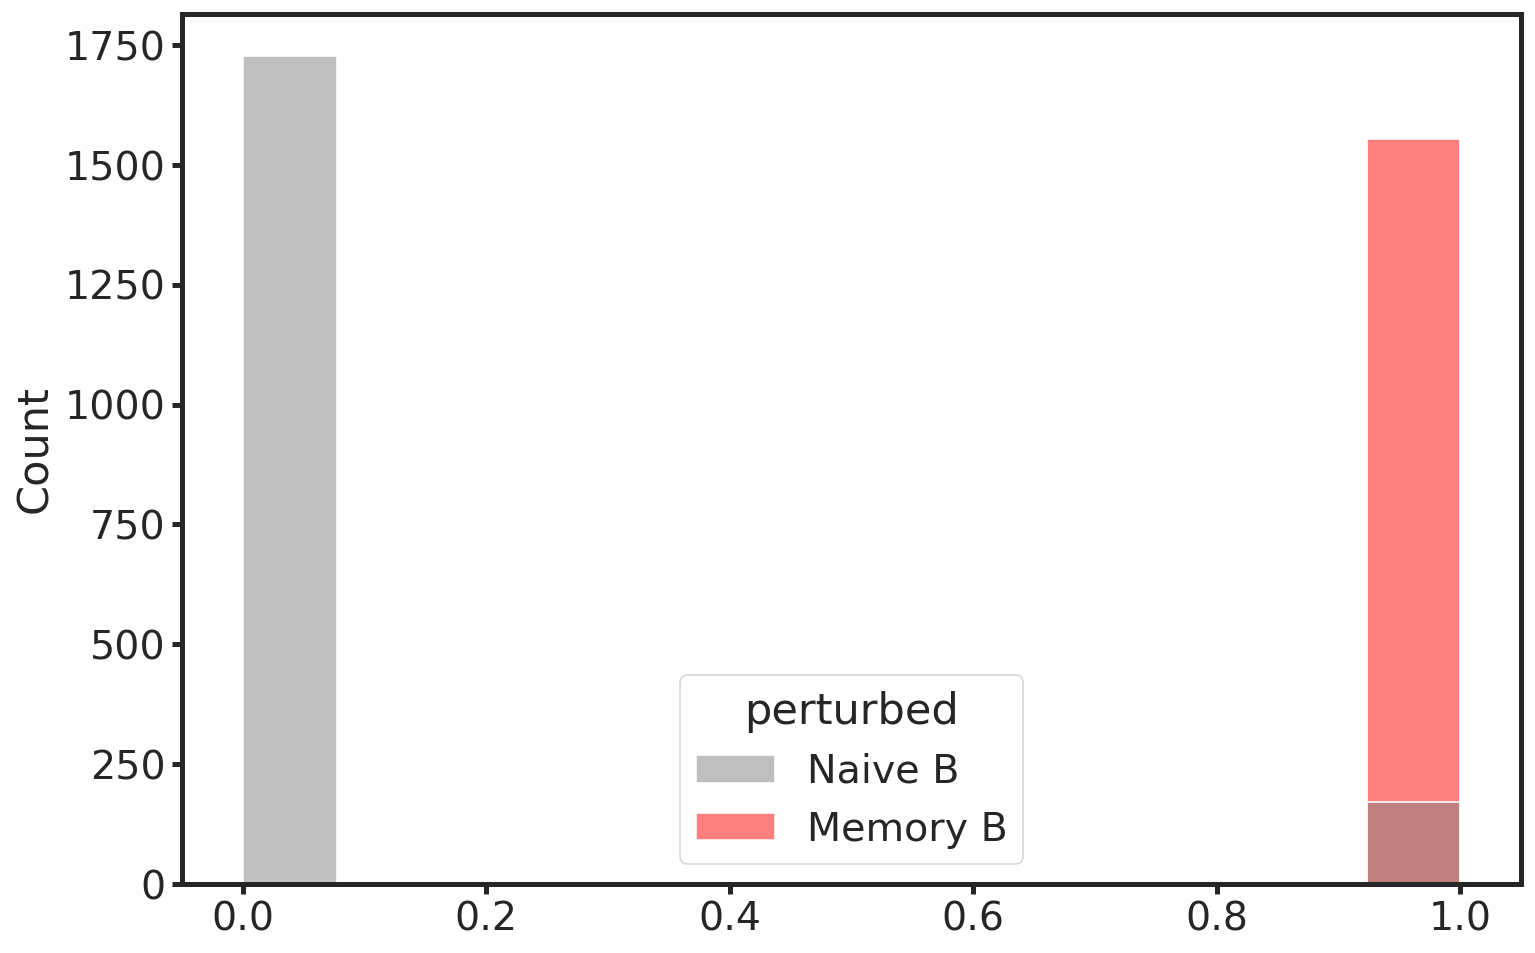

In [171]:
p_hat = standalone_logistic(scaled_log_normalized_expression_ng,#log_normalized_expression_ng,
                    batch.astype(np.float32))
df_p_hat = pd.DataFrame()
df_p_hat['p_hat'] = p_hat
df_p_hat['perturbed'] = perturbed

sns.histplot(x=p_hat,#np.exp(-tmp), 
             hue='perturbed', 
             palette={'Naive B':'gray','Memory B':'red'},
             data=df_p_hat)
plt.show()

In [172]:
#log_normalized_expression_ng

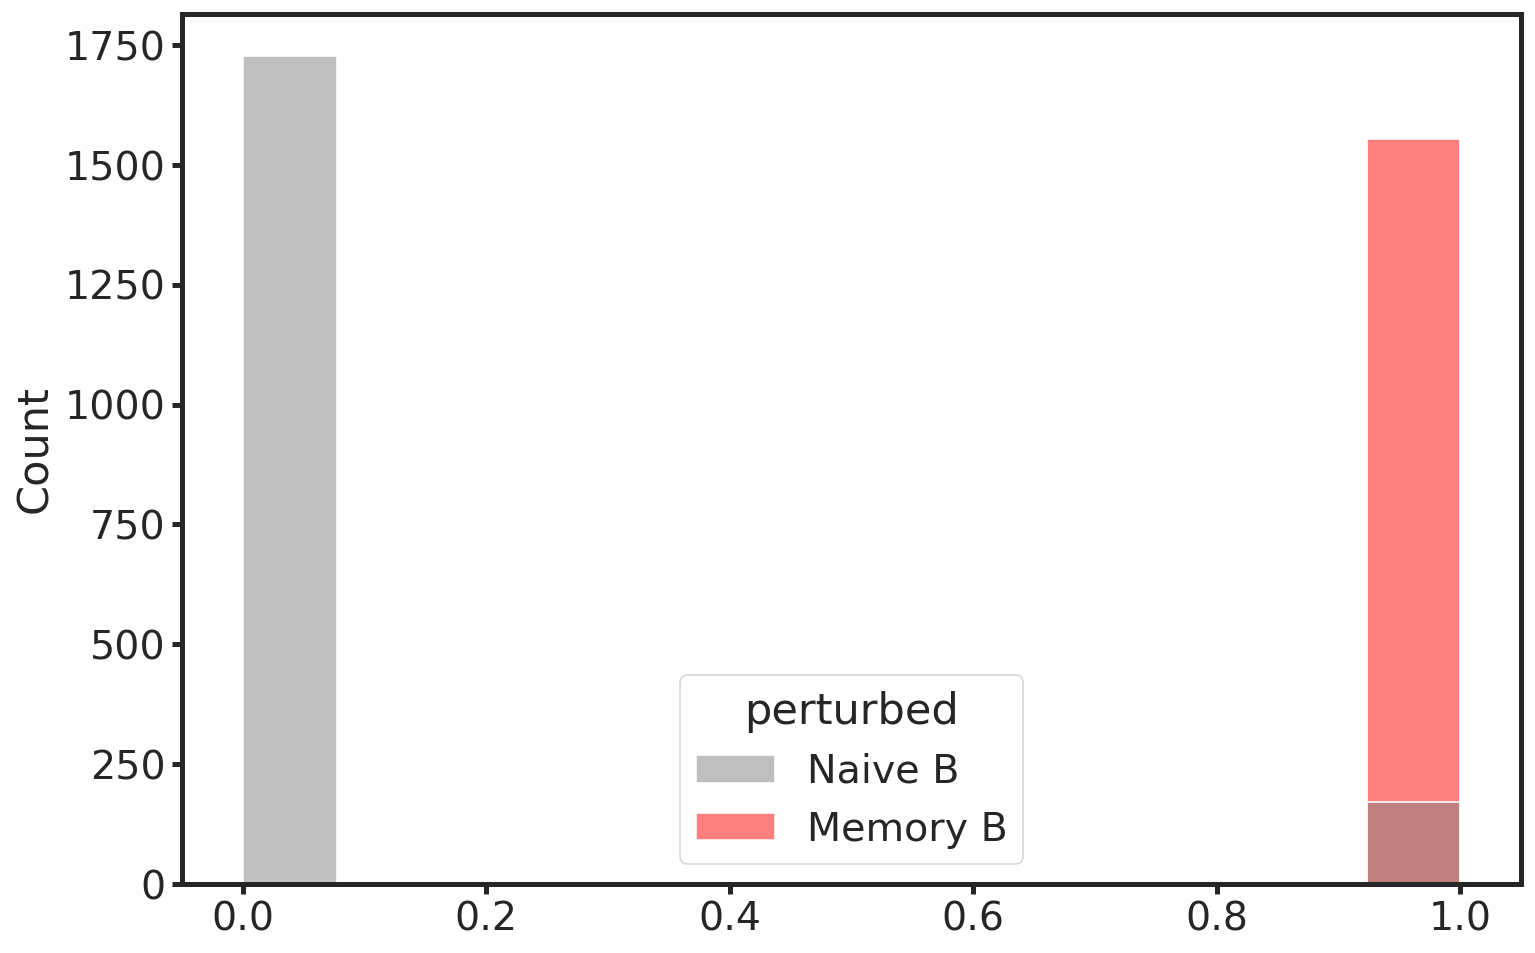

In [173]:
p_hat = standalone_logistic(log_normalized_expression_ng,
                    batch.astype(np.float32))
df_p_hat = pd.DataFrame()
df_p_hat['p_hat'] = p_hat
df_p_hat['perturbed'] = perturbed

sns.histplot(x=p_hat,#np.exp(-tmp), 
             hue='perturbed', 
             palette={'Naive B':'gray','Memory B':'red'},
             data=df_p_hat)
plt.show()

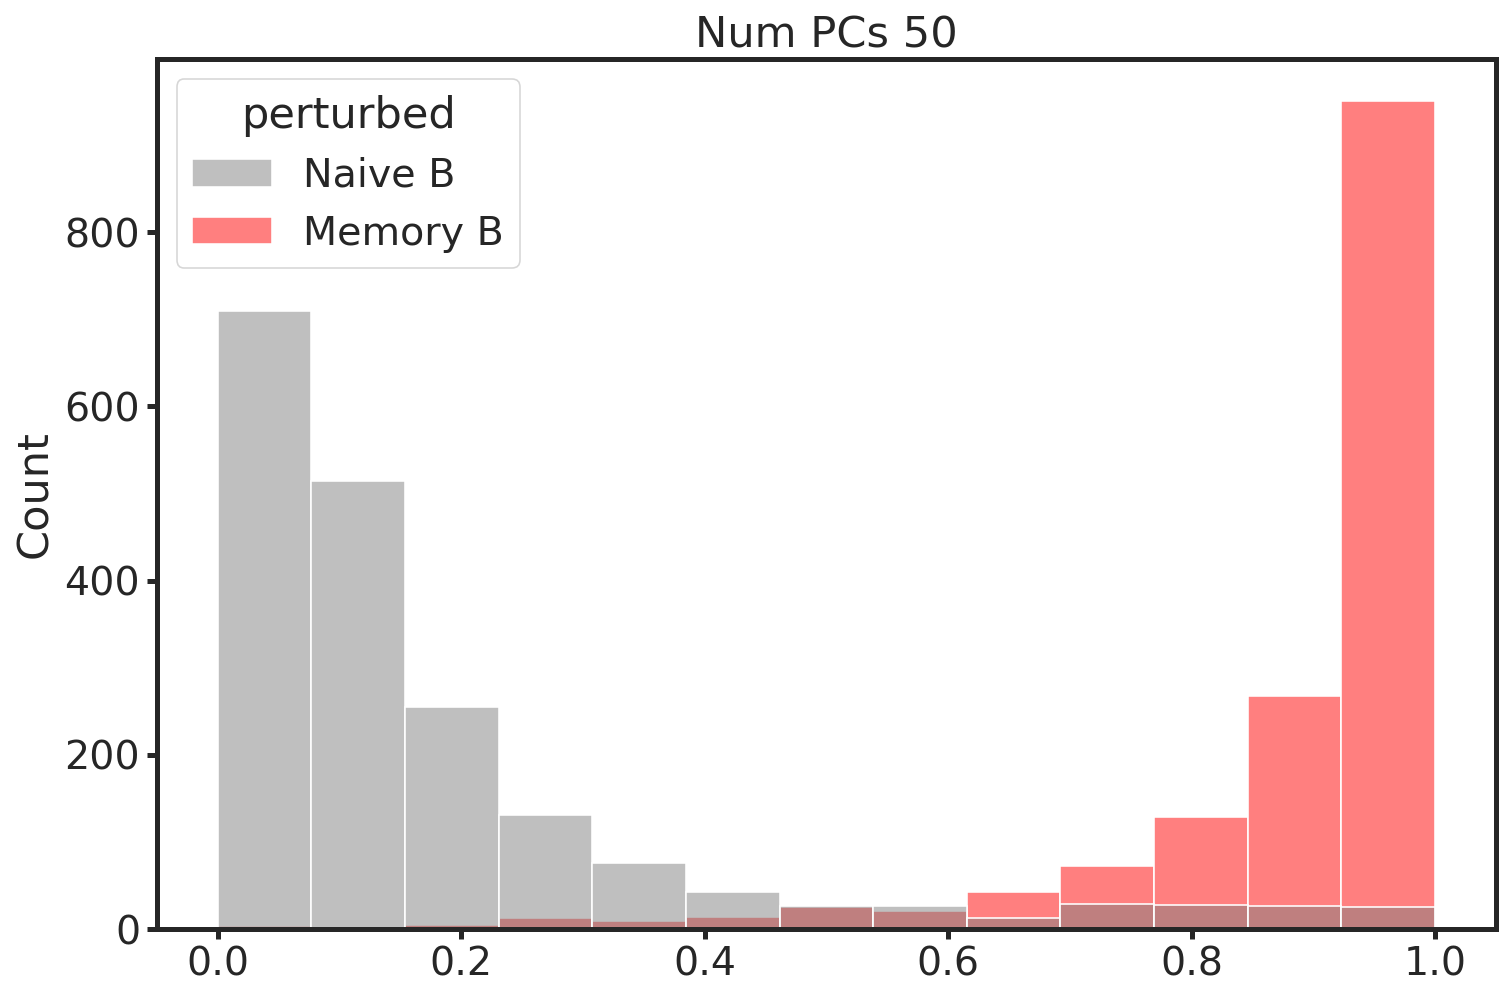

In [174]:
p_hat = standalone_logistic(adata.obsm['X_pca'],
                    batch.astype(np.float32))
df_p_hat = pd.DataFrame()
df_p_hat['p_hat'] = p_hat
df_p_hat['perturbed'] = perturbed
#df_tmp
sns.histplot(x=p_hat,
             hue='perturbed', 
             palette={'Naive B':'gray','Memory B':'red'},
             data=df_p_hat)
num_pcs = adata.obsm['X_pca'].shape[1]
plt.title(f'Num PCs {num_pcs}')
plt.show()

/opt/conda/envs/vizi/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


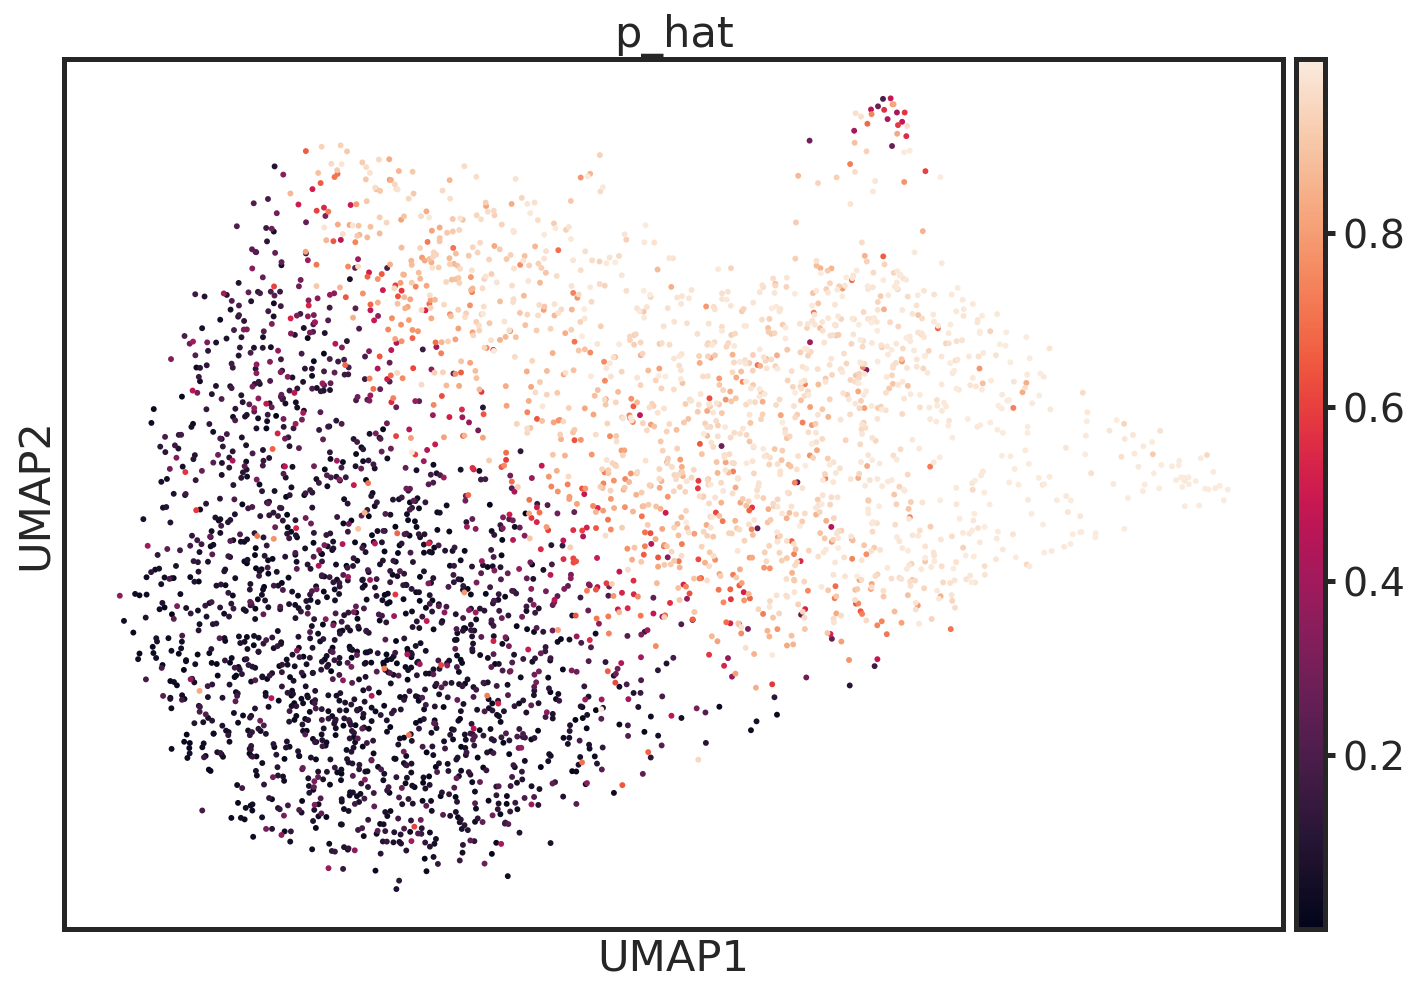

In [175]:
adata.obs['p_hat'] = p_hat
sc.pl.umap(adata, color='p_hat')

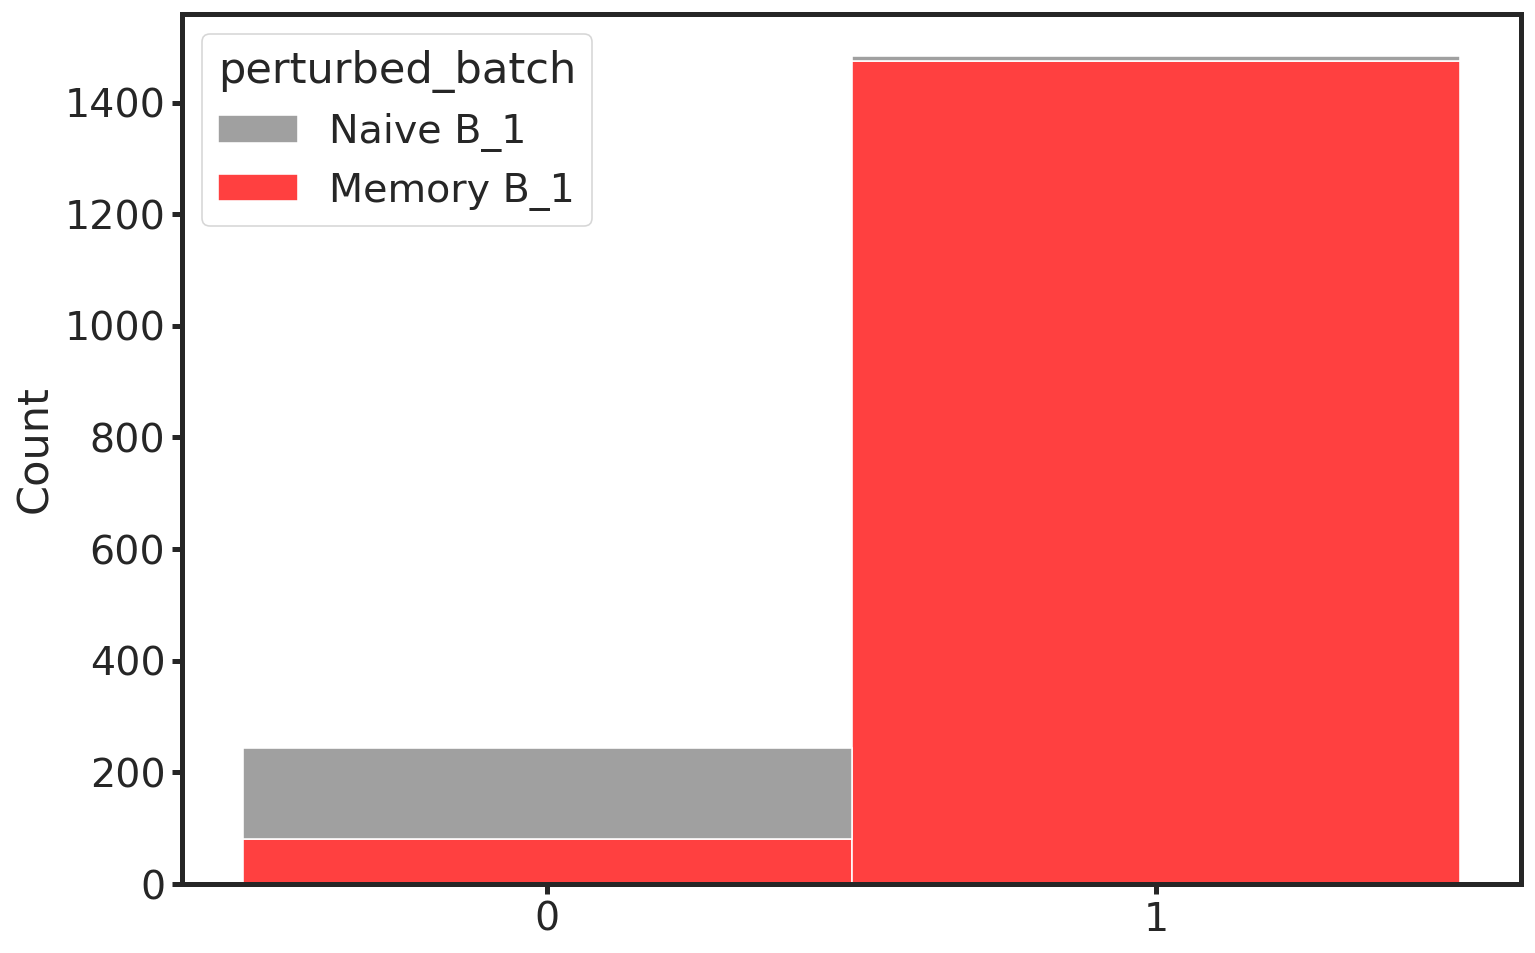

In [176]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(pd.DataFrame(p_hat)[batch==1])#(df.drop(['batch', 'perturbed'], axis=1))
kmeans.labels_
#kmeans.cluster_centers_

df = pd.DataFrame()
df['batch'] = adata.obs['batch'].values.astype(int)
df['perturbed'] = adata.obs['perturbed'].values
df_kmeans = df[batch==1].copy()
df_kmeans['perturbed_batch'] = df_kmeans.apply(lambda row: f'{row["perturbed"]}_{row["batch"]}', axis=1)
df_kmeans['kmeans_labels'] = kmeans.labels_
#df_kmeans.head()
sns.histplot(x=kmeans.labels_.astype('str'), 
             hue='perturbed_batch', 
             palette=['gray', 'red'],#sns.color_palette('Dark2', 2), 
             multiple='stack', 
             data=df_kmeans)
plt.show()

In [177]:
kmeans.cluster_centers_
# can try a gaussian mixture too
# maybe LDA also?

array([[0.22663035],
       [0.9180321 ]])

<ipython-input-178-be6db1941019>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p_hat['kmeans'][batch==1] = kmeans.labels_


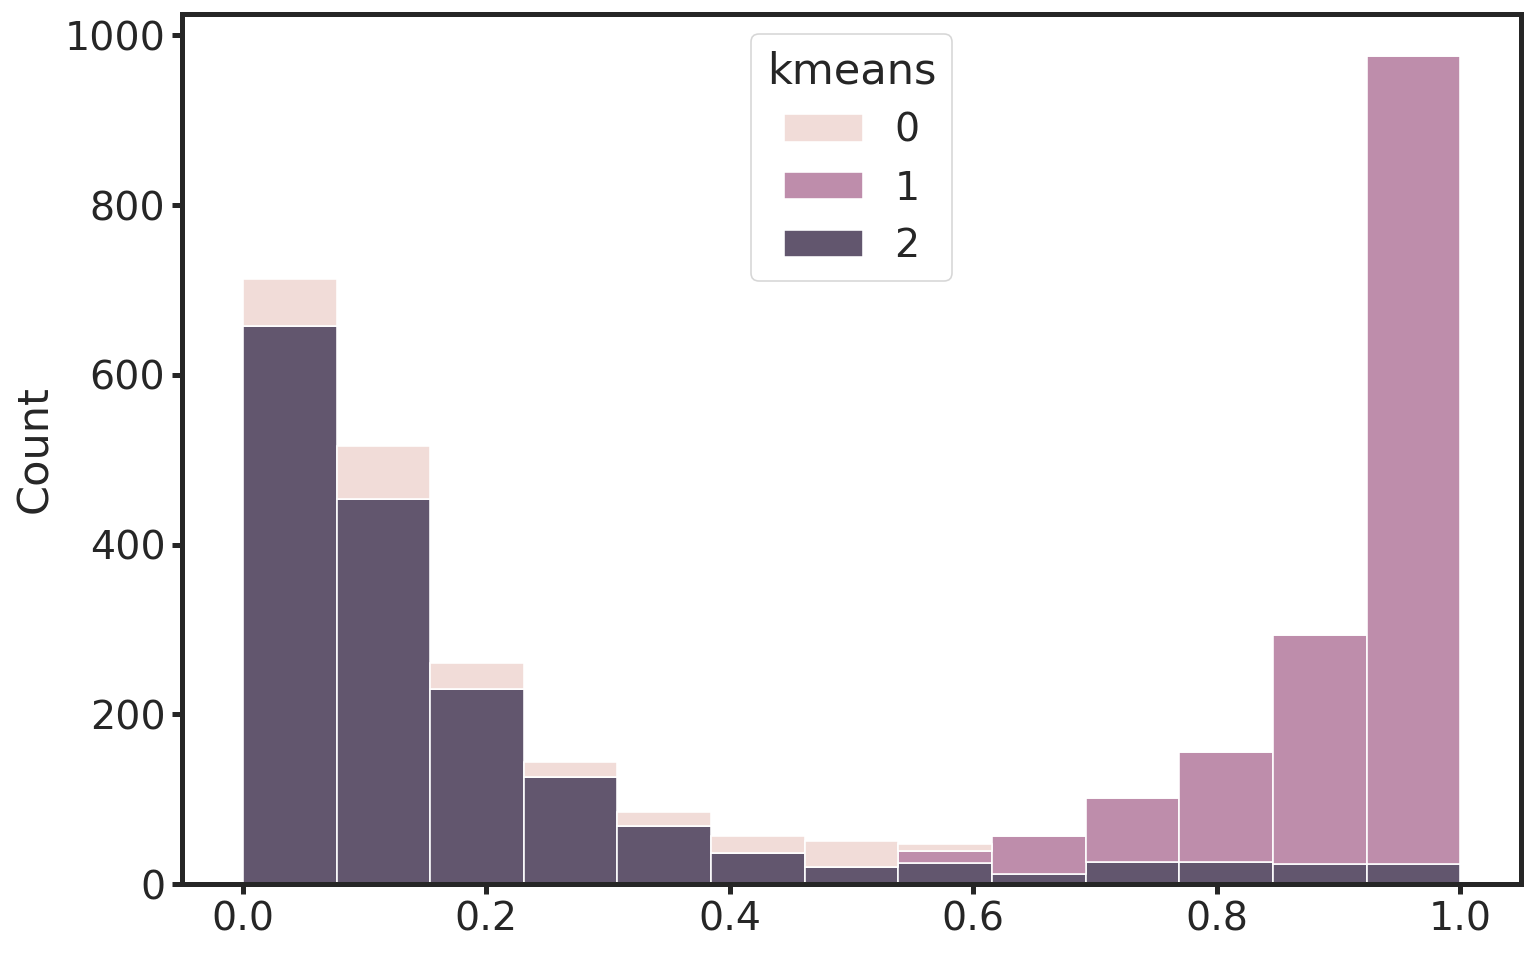

In [178]:
df_p_hat['kmeans'] = 2
df_p_hat['kmeans'][batch==1] = kmeans.labels_
sns.histplot(x=p_hat,
             hue='kmeans', 
             #palette={'Naive B':'gray','Memory B':'red'},
             data=df_p_hat,
             multiple='stack')
num_pcs = adata.obsm['X_pca'].shape[1]
#plt.title(f'Num PCs {num_pcs}')
plt.show()

/opt/conda/envs/vizi/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'kmeans_labels' as categorical
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequenc

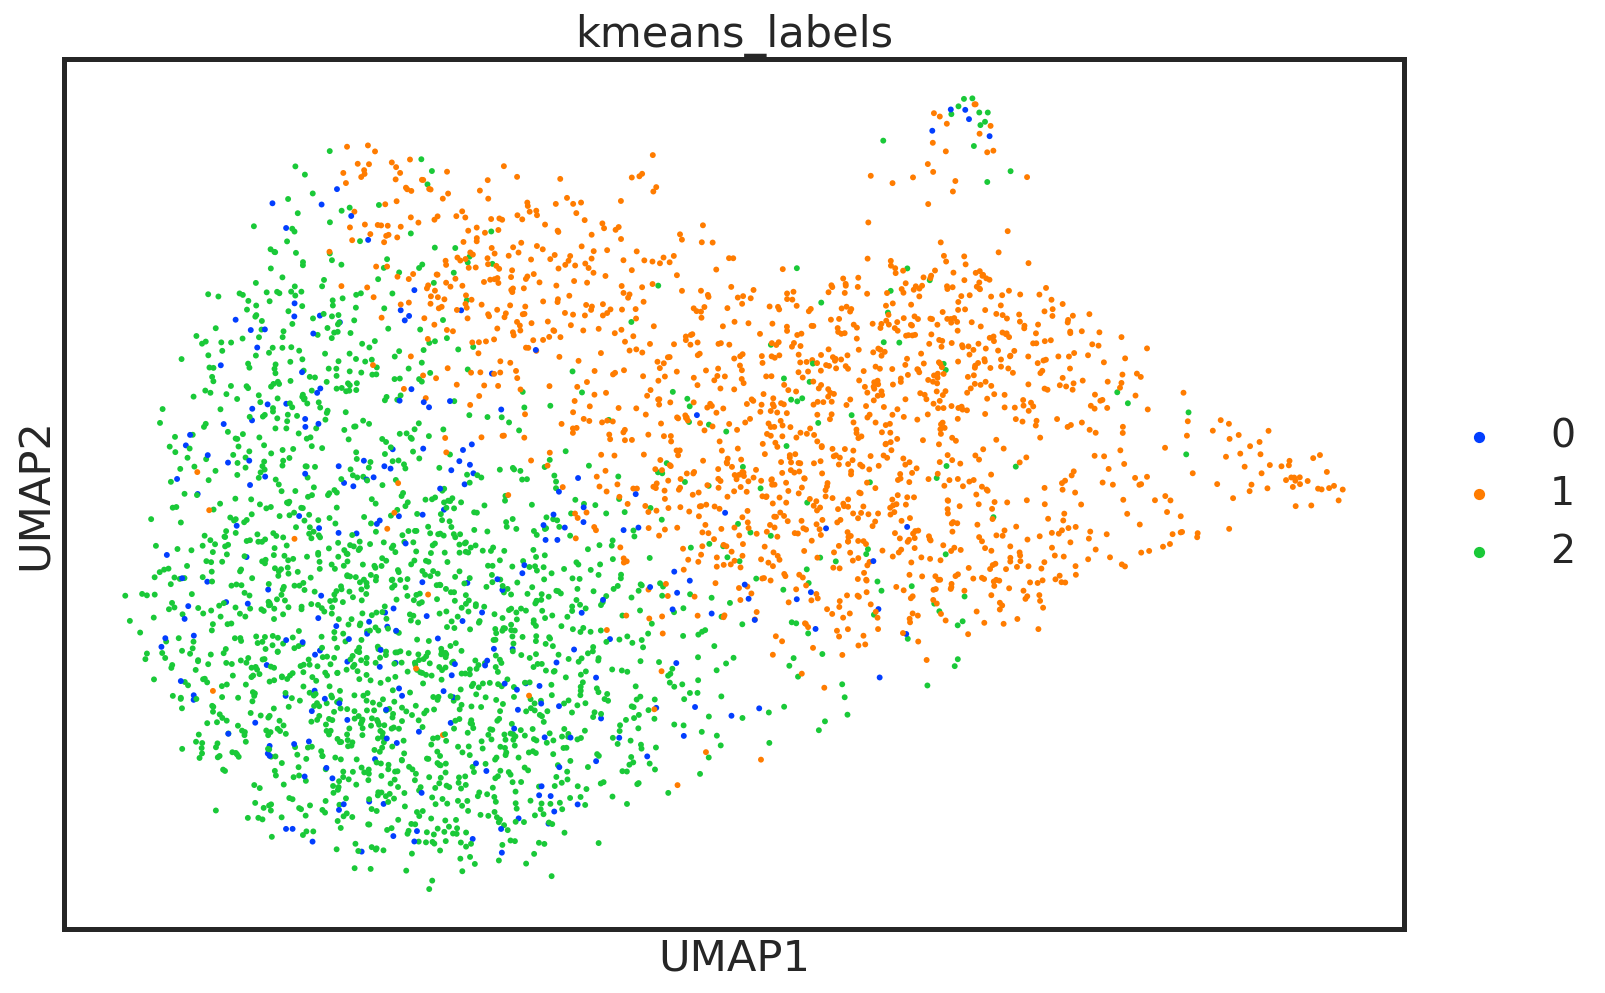

In [179]:
adata.obs['kmeans_labels'] = df_p_hat['kmeans'].values.astype('str')
sc.pl.umap(adata, color='kmeans_labels')

In [180]:
plt.scatter(tmp[batch==1], tmp[batch==1], c=kmeans.labels_==1, alpha=0.5)
# i want a two by two table, with perturbed/nnot perturbed, and kmeans label 0 and 1

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2054 but corresponding boolean dimension is 3455

In [181]:
plt.scatter(tmp[batch==1], tmp[batch==1], c=perturbed[batch==1]=='Memory B', alpha=0.5)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2054 but corresponding boolean dimension is 3455